### GBSG2 Exploratory Data Analysis

This section provides a quick EDA of the German Breast Cancer Study Group 2 (GBSG2) dataset.

- Dataset overview and schema
- Missing values and basic summaries
- Distributions of categorical and numeric variables
- Survival outcome summary
- Kaplan–Meier curves (overall and by tumor grade `tgrade`)
- Key cross-tabs between clinical variables


In [70]:
# clear all variables
%reset -f

In [71]:
# Setup: load data and common libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sksurv.datasets import load_gbsg2
from sksurv.util import Surv
from sksurv.nonparametric import kaplan_meier_estimator

plt.style.use("default")
sns.set_context("talk")

# Load dataset
X_df, y = load_gbsg2()
print(f"Shape: {X_df.shape}")
X_df.head()


Shape: (686, 8)


,age,estrec,horTh,menostat,pnodes,progrec,tgrade,tsize
0,70.0,66.0,no,Post,3.0,48.0,II,21.0
1,56.0,77.0,yes,Post,7.0,61.0,II,12.0
2,58.0,271.0,yes,Post,9.0,52.0,II,35.0
3,59.0,29.0,yes,Post,4.0,60.0,II,17.0
4,73.0,65.0,no,Post,1.0,26.0,II,35.0


#### Overview, schema, and missingness


In [72]:
# Dtypes and basic info
print(X_df.dtypes)

# Missingness
missing = X_df.isna().sum().sort_values(ascending=False)
print("\nMissing values per column:\n", missing)

# Quick stats for numeric columns
display(X_df.describe().T)


age          float64
estrec       float64
horTh       category
menostat    category
pnodes       float64
progrec      float64
tgrade      category
tsize        float64
dtype: object

Missing values per column:
 age         0
estrec      0
horTh       0
menostat    0
pnodes      0
progrec     0
tgrade      0
tsize       0
dtype: int64


,count,mean,std,min,25%,50%,75%,max
age,686.0,53.052478,10.120739,21.0,46.0,53.0,61.00,80.0
estrec,686.0,96.252187,153.083963,0.0,8.0,36.0,114.00,1144.0
pnodes,686.0,5.010204,5.475483,1.0,1.0,3.0,7.00,51.0
progrec,686.0,109.995627,202.331552,0.0,7.0,32.5,131.75,2380.0
tsize,686.0,29.329446,14.296217,3.0,20.0,25.0,35.00,120.0


#### Categorical distributions


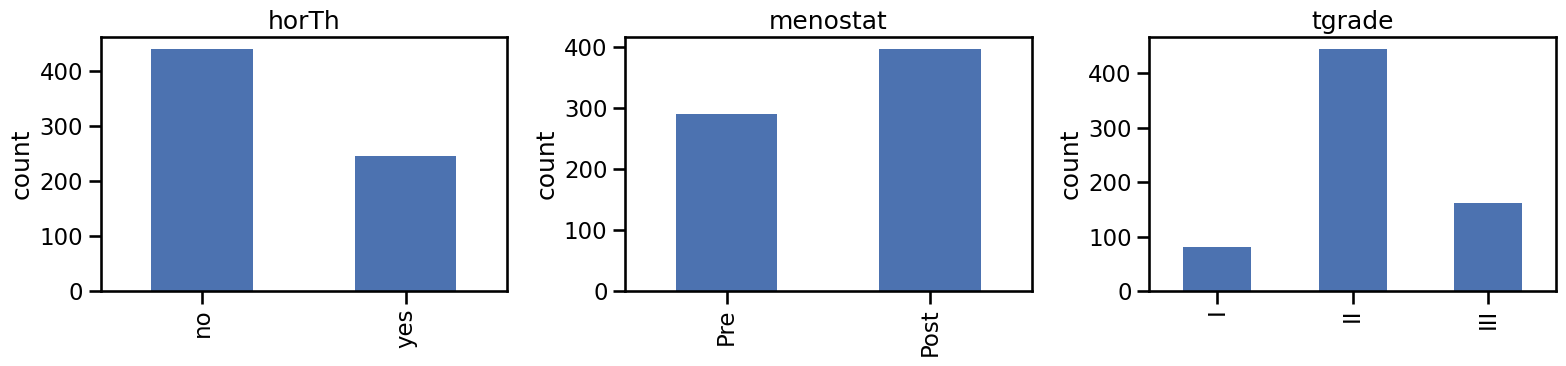

In [73]:
# Bar plots for categorical variables
categorical_cols = ["horTh", "menostat", "tgrade"]
fig, axes = plt.subplots(1, len(categorical_cols), figsize=(16, 4))
for ax, col in zip(axes, categorical_cols):
    X_df[col].value_counts().sort_index().plot(kind="bar", ax=ax, color="#4C72B0")
    ax.set_title(col)
    ax.set_xlabel("")
    ax.set_ylabel("count")
plt.tight_layout()
plt.show()


#### Numeric distributions


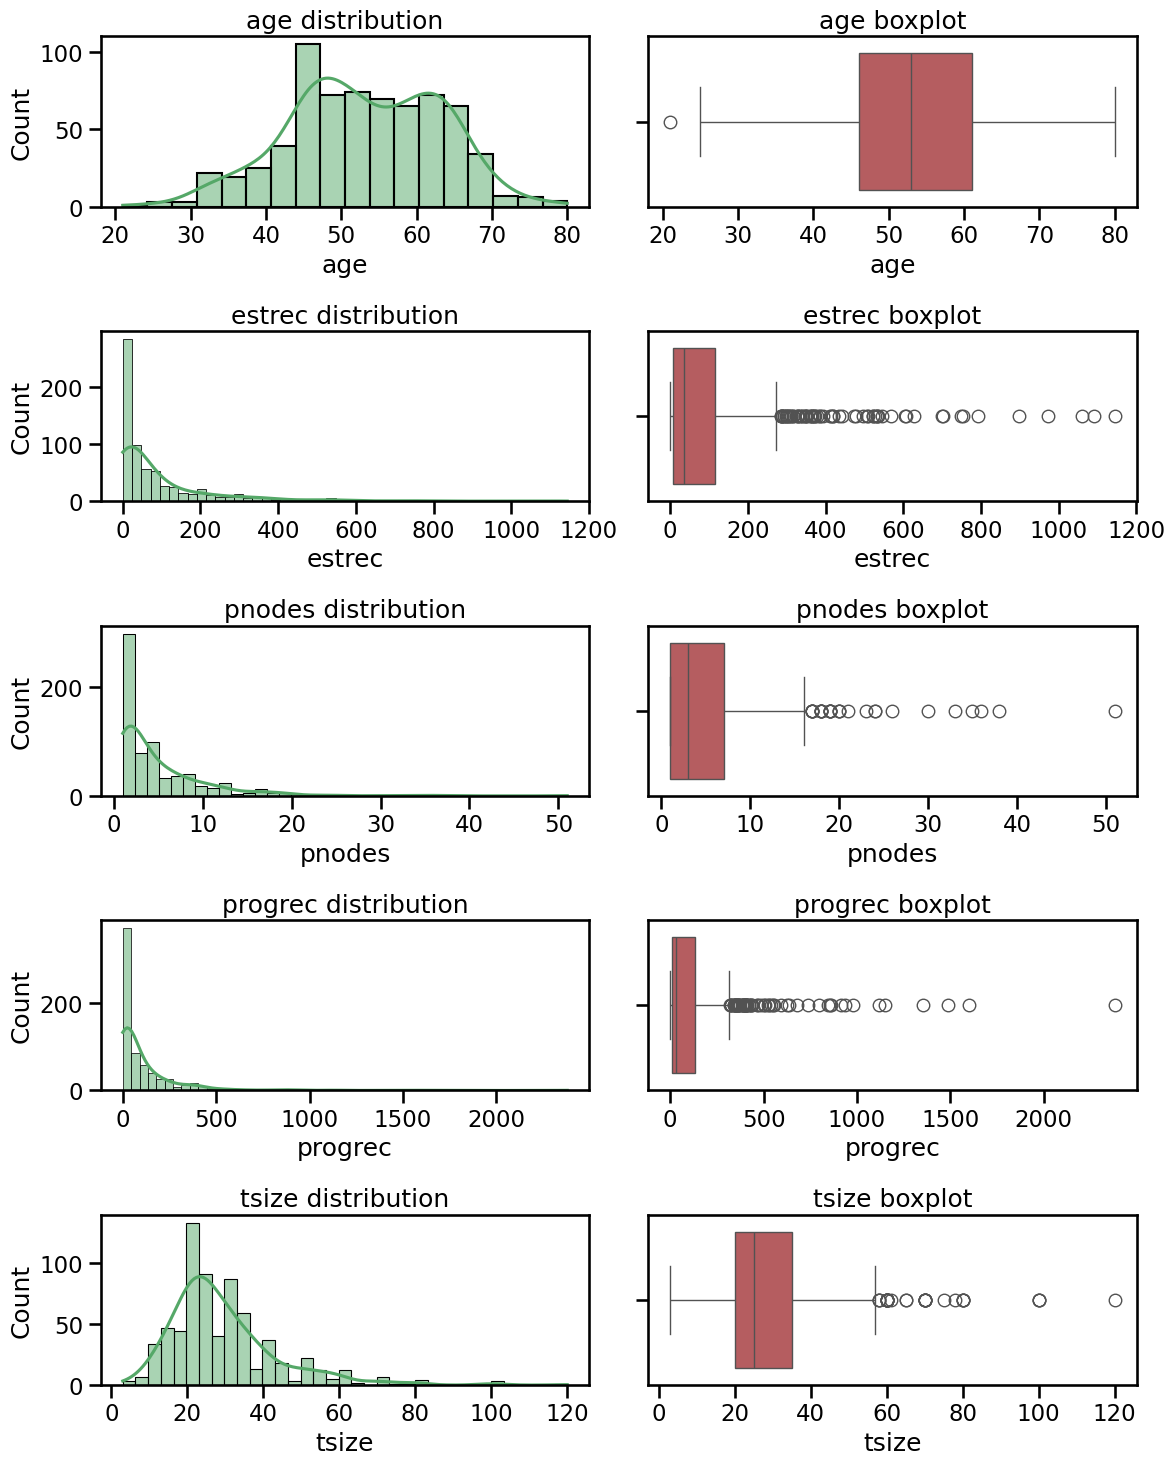

In [74]:
# Histograms and boxplots for numeric variables
numeric_cols = ["age", "estrec", "pnodes", "progrec", "tsize"]
fig, axes = plt.subplots(len(numeric_cols), 2, figsize=(12, 3*len(numeric_cols)), sharex=False)
for i, col in enumerate(numeric_cols):
    sns.histplot(X_df[col], kde=True, ax=axes[i, 0], color="#55A868")
    axes[i, 0].set_title(f"{col} distribution")
    sns.boxplot(x=X_df[col], ax=axes[i, 1], color="#C44E52")
    axes[i, 1].set_title(f"{col} boxplot")
plt.tight_layout()
plt.show()


#### Survival outcome summary


In [75]:
# Survival summary
events = y['cens']  # True = event occurred
surv_time = y['time']
print(f"Events: {events.sum()} / {len(events)} ({events.mean()*100:.1f}%)")
print(f"Time min/median/mean/max: {surv_time.min():.1f} / {np.median(surv_time):.1f} / {surv_time.mean():.1f} / {surv_time.max():.1f}")


Events: 299 / 686 (43.6%)
Time min/median/mean/max: 8.0 / 1084.0 / 1124.5 / 2659.0


#### Kaplan–Meier curves (overall and by tgrade)


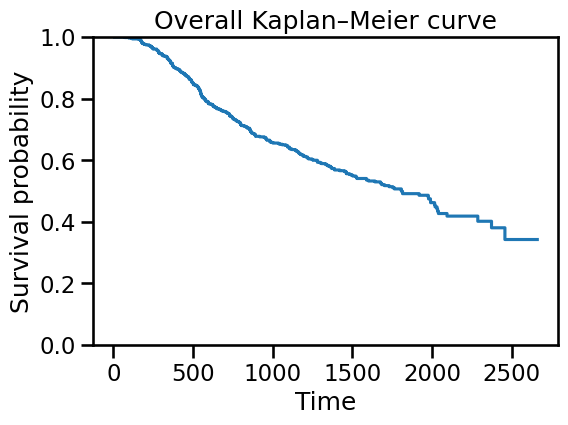

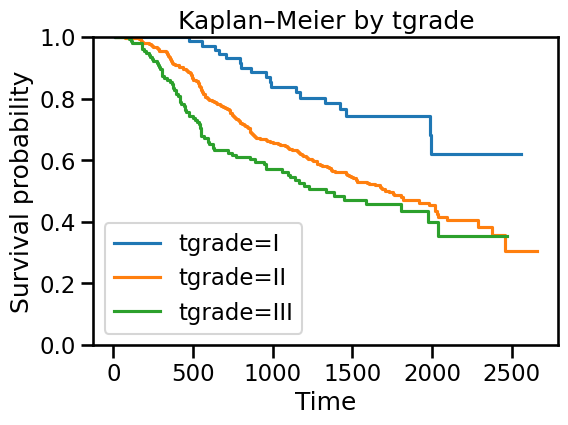

In [76]:
# Overall KM curve
from sksurv.nonparametric import kaplan_meier_estimator

event_indicator = y['cens'].astype(bool)
event_time = y['time'].astype(float)

times, surv_prob = kaplan_meier_estimator(event_indicator, event_time)
plt.figure(figsize=(6,4))
plt.step(times, surv_prob, where="post")
plt.xlabel("Time")
plt.ylabel("Survival probability")
plt.title("Overall Kaplan–Meier curve")
plt.ylim(0, 1.0)
plt.show()

# KM curves by tgrade
plt.figure(figsize=(6,4))
for grade in ["I", "II", "III"]:
    mask = (X_df["tgrade"].astype(str) == grade)
    if mask.sum() == 0:
        continue
    t, s = kaplan_meier_estimator(event_indicator[mask], event_time[mask])
    plt.step(t, s, where="post", label=f"tgrade={grade}")
plt.xlabel("Time")
plt.ylabel("Survival probability")
plt.title("Kaplan–Meier by tgrade")
plt.ylim(0, 1.0)
plt.legend()
plt.show()


# Example Notebook w/ GBSG2

This notebook demonstrated how to use `SurvivalLVQ` clustering to handle GVSG2(German Breast Cancer Study). 
- 686 samples, 8 features, endpoint: recurrence-free survival 

### Preprocess the features 

In [77]:
import pandas as pd

print(X_df.horTh.unique())
print(X_df.menostat.unique())
print(X_df.tgrade.unique())
print(X_df.shape)

# convert categorical features using one-hot encoding
cats = ['horTh', 'menostat', 'tgrade'] # categorical features 
num_col = ['age', 'estrec', 'pnodes', 'progrec', 'tsize'] # numerical features
cat_ids = [X_df.columns.get_loc(col) for col in cats]
num_col_ids = [X_df.columns.get_loc(col) for col in num_col]

print(cat_ids)
print(num_col_ids)

['no', 'yes']
Categories (2, object): ['no', 'yes']
['Post', 'Pre']
Categories (2, object): ['Pre', 'Post']
['II', 'III', 'I']
Categories (3, object): ['I', 'II', 'III']
(686, 8)
[2, 3, 6]
[0, 1, 4, 5, 7]


### Prepare the data for the survival model

In [78]:
# Implementation: SurvivalLVQ with 3 prototypes to predict tgrade
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

from Models.SurvivalLVQ import SurvivalLVQ
from SkewTransformer import SkewTransformer

D = y['cens']        # censoring indicator
T = y['time']        # survival time

# Prepare inputs and encode categorical variables
def preprocess_data(X_df, y, test_size=0.2, random_state=42):
    # convert categorical to one-hot encoding
    X_processed = X_df.copy()
    X_processed = pd.get_dummies(X_processed, columns = cats) # one-hot encoding
    X_array = X_processed.values.astype(float) # convert to numpy array 

    # split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_array, y, test_size=test_size, random_state=random_state, stratify=D
    )

    # impute missing values
    imp = SimpleImputer(missing_values=np.nan, strategy='median')
    X_train = imp.fit_transform(X_train)
    X_test = imp.fit_transform(X_test)

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = preprocess_data(X_df, y)

# transform numerical features
scaler = SkewTransformer()
scaler.fit(X_train[:, num_col_ids])
X_train[:, num_col_ids] = scaler.transform(X_train[:, num_col_ids])
X_test[:, num_col_ids] = scaler.transform(X_test[:, num_col_ids])

In [79]:
mod = SurvivalLVQ(n_prototypes=2, epochs=50, lr=1e-2, verbose=True)
mod.fit(X_train, y_train)


Epoch: 1 / 50 | Loss: 0.276056
Epoch: 2 / 50 | Loss: 0.275815
Epoch: 3 / 50 | Loss: 0.276931
Epoch: 4 / 50 | Loss: 0.273904
Epoch: 5 / 50 | Loss: 0.276240
Epoch: 6 / 50 | Loss: 0.278295
Epoch: 7 / 50 | Loss: 0.275032
Epoch: 8 / 50 | Loss: 0.277434
Epoch: 9 / 50 | Loss: 0.271261
Epoch: 10 / 50 | Loss: 0.273065
Epoch: 11 / 50 | Loss: 0.270728
Epoch: 12 / 50 | Loss: 0.278443
Epoch: 13 / 50 | Loss: 0.278996
Epoch: 14 / 50 | Loss: 0.268548
Epoch: 15 / 50 | Loss: 0.273030
Epoch: 16 / 50 | Loss: 0.272868
Epoch: 17 / 50 | Loss: 0.273833
Epoch: 18 / 50 | Loss: 0.277690
Epoch: 19 / 50 | Loss: 0.272028
Epoch: 20 / 50 | Loss: 0.275584
Epoch: 21 / 50 | Loss: 0.274490
Epoch: 22 / 50 | Loss: 0.270604
Epoch: 23 / 50 | Loss: 0.277667
Epoch: 24 / 50 | Loss: 0.277146
Epoch: 25 / 50 | Loss: 0.272436
Epoch: 26 / 50 | Loss: 0.274307
Epoch: 27 / 50 | Loss: 0.272465
Epoch: 28 / 50 | Loss: 0.264612
Epoch: 29 / 50 | Loss: 0.269534
Epoch: 30 / 50 | Loss: 0.267241
Epoch: 31 / 50 | Loss: 0.265080
Epoch: 32 / 50 | 

SurvivalLVQ()

variance coverd by projection: tensor(97.6609)


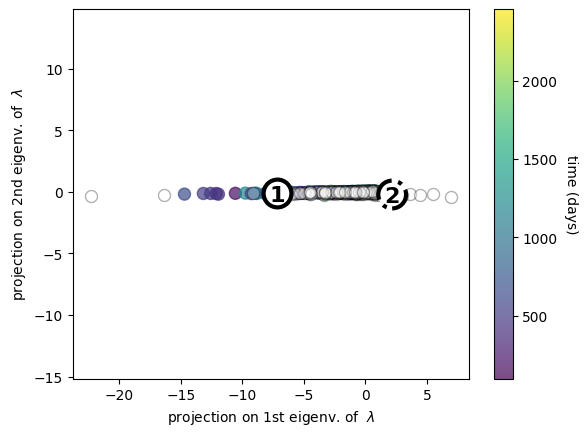

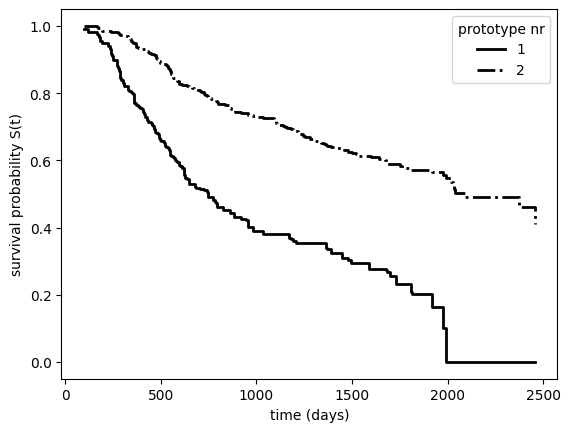

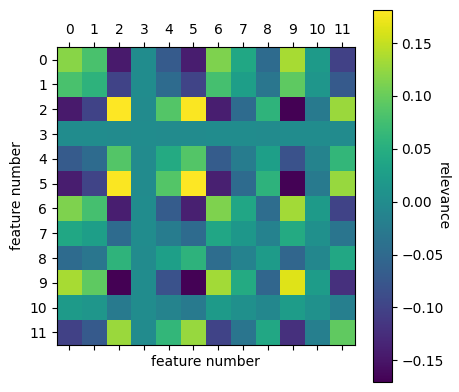

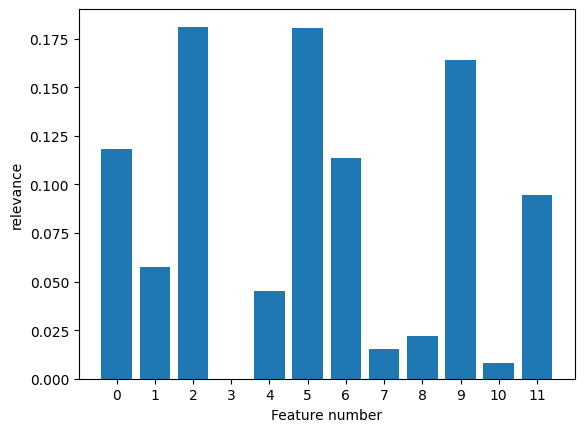

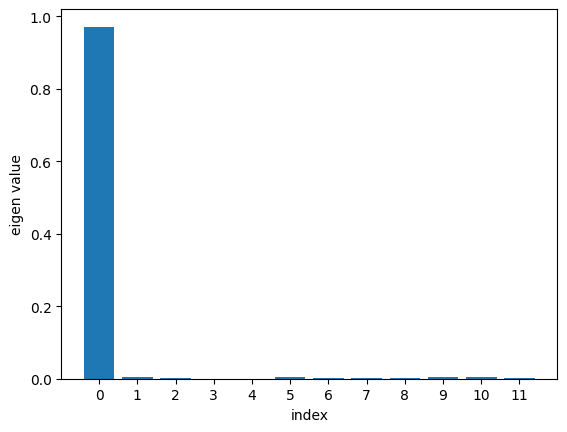

In [80]:
D_train, T_train = map(np.array, zip(*y_train))
mod.vis(X_train, D_train, T_train)